In [1]:
from qslamr import *
from model_design import INITIALDICT, GRIDDICT

In [2]:
positions = GRIDDICT.values()
test = ParticleFilter(positions, **INITIALDICT)
measurement_controls = [[0, 0], [0, 2]]*2 # an upstate on Qubit 1 and Qubit 3

In [3]:
test.qslamr(measurement_controls)

Initial alpha weights (below) are uniformly distributed...
[ 0.33333333  0.33333333  0.33333333]
and alpha_weights sum to 1:
1.0


 NEW MSMT


 PROPAGATE


 COMPUTER WEIGHTS 


in alpha_weight_calc, old_weight 0.333333333333
in alpha_weight_calc, likelihood 0.184373190186


in alpha_weight_calc, old_weight 0.333333333333
in alpha_weight_calc, likelihood 0.184373190186


in alpha_weight_calc, old_weight 0.333333333333
in alpha_weight_calc, likelihood 0.184373190186

raw_weights in calc_weights_set [ 0.06145773  0.06145773  0.06145773]

In generate_beta_layer, list_of_parent_states = [array([ 0.2890655 , -0.84116225, -0.82047435,  0.62359332,  0.47606547,
       -0.57849315,  3.14159265,  1.        ,  1.        ,  2.1830437 ,
       -0.02080694, -0.37065933]), array([ 0.2890655 , -0.84116225, -0.82047435,  0.62359332,  0.47606547,
       -0.57849315,  3.14159265,  1.        ,  1.        ,  2.1830437 ,
       -0.02080694, -0.37065933]), array([ 0.2890655 , -0.84116225, -0.82047435,  0.623

#### Testing the subtree generation - particularly the last tree:

#### Testing whether the resamplign function picks out all indices

In [4]:
import numpy as np

class Resample(object):
    '''docstring'''
    
    def __init__(self):
        pass
    
    @staticmethod
    def resample_from_weights(posterior_weights, number_of_samples):
        '''docstring'''
        total_particles = len(posterior_weights)
        cdf_weights = np.asarray([0] + [np.sum(posterior_weights[:idx+1]) for idx in range(total_particles)])
        pdf_uniform = np.random.uniform(low=0, high=1.0, size=number_of_samples)

        resampled_idx = []

        for u_0 in pdf_uniform:
            j = 0
            while u_0 > cdf_weights[j]:
                j += 1
                if j > total_particles:
                    j = total_particles 
                    # print('Break - max particle index reached during sampling')
                    break   # clip at max particle index, plus zero
            resampled_idx.append(j-1) # sgift down to match python indices

        return resampled_idx    
    
    @staticmethod
    def get_subtrees(resampled_indices, pset_beta):
        '''docstring'''
    
        new_sub_trees = []

        resampled_indices.sort()
        alpha_index_0 = None
        strt_counter=0
        end_counter=0

        for idx in resampled_indices:

            alpha_index = Resample.get_alpha_node_from_treeleaf(idx, pset_beta)
            beta_alpha_idx = Resample.get_beta_node_from_treeleaf(idx, pset_beta)

            if alpha_index_0 == alpha_index:
                end_counter +=1

            elif alpha_index_0 != alpha_index:

                new_sub_trees.append([strt_counter, end_counter])

                alpha_index_0 = alpha_index
                strt_counter = end_counter
                end_counter += 1

        if end_counter == len(resampled_indices):
            end_counter += 1
            new_sub_trees.append([strt_counter, end_counter])

        return new_sub_trees
    
    @staticmethod
    def get_alpha_node_from_treeleaf(leaf_index, pset_beta):
        '''docstring'''
        alpha_node = int(leaf_index//float(pset_beta))
        return alpha_node

    @staticmethod
    def get_beta_node_from_treeleaf(leaf_index, pset_beta):
        '''docstring'''
        beta_node = int(leaf_index - int(leaf_index//float(pset_beta))*pset_beta)
        return beta_node
    
    @staticmethod
    def collapse_beta(subtree_list, resampled_indices, pset_beta):
        '''docstring'''

        state_update = 0.
        new_alpha_particle_list = []
        
        for subtree in subtree_list:

            leaves_of_subtree = resampled_indices[subtree[0]:subtree[1]]
            leaf_count = float(len(leaves_of_subtree))
            print "The subtree is defined by the endpoint index boundaries", subtree
            print "The leaves of the subtree are ", leaves_of_subtree

            if leaf_count != 0:

                normaliser = (1./leaf_count)
                alpha_node = Resample.get_alpha_node_from_treeleaf(leaves_of_subtree[0], pset_beta)
                               # resampled_indices[subtree[0]], pset_beta)
                beta_alpha_nodes = [Resample.get_beta_node_from_treeleaf(leafy, pset_beta) for leafy in leaves_of_subtree]
                               # resampled_indices[subtree[0]:subtree[1]]] 
                print "The subtree has alpha node of: ", alpha_node 
                print "The leaves of the subtree are labeled by beta indices", beta_alpha_nodes
                
#                 r_est_subtree = 0.0
#                 for node in beta_alpha_nodes:
                    
#                     beta_state = self.AlphaSet.particles[alpha_node].BetaAlphaSet_j.particles[node].particle
#                     node_j = self.AlphaSet.particles[alpha_node].node_j
#                     beta_lengthscale = beta_state[int(node_j)]
#                     r_est_subtree += normaliser*beta_lengthscale

#                 parent = self.AlphaSet.particles[alpha_node].particle
#                 parent[self.AlphaSet.particles[alpha_node].node_j] = r_est_subtree

#                 # Beta Layer Collapsed
#                 self.AlphaSet.particles[alpha_node].particle = parent
#                 self.AlphaSet.particles[alpha_node].BetaAlphaSet_j = None

#                 # New Alphas Stored
#                 new_alpha_particle_list.append(self.AlphaSet.particles[alpha_node])
#         print
#         return new_alpha_particle_list


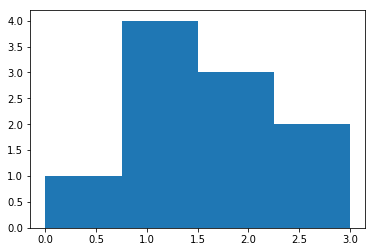

unique values set([0, 1])
resamp [3, 1, 3, 0, 1, 1, 2, 1, 2, 2]
alphas [1, 0, 1, 0, 0, 0, 1, 0, 1, 1]
True
True


In [5]:
pset_alpha=2 #0 ==== 1==== 2 ===
pset_beta=2 #0, 1 == 2, 3, == 4,5
particles = pset_beta*pset_alpha
posterior_weights = list((1.0 / float(particles))*np.ones(particles))
number_of_samples = 10

resampled = Resample.resample_from_weights(posterior_weights, number_of_samples)
alphas = [Resample.get_alpha_node_from_treeleaf(index, pset_beta) for index in resampled]

import matplotlib.pyplot as plt
plt.figure()
plt.hist(resampled, bins=len(posterior_weights))
plt.show()

print "unique values", set(list(alphas))
print "resamp", resampled
print "alphas", alphas
print len( set(list(resampled))) == particles
print len( set(list(alphas))) == pset_alpha

In [6]:
subtree_boundaries = Resample.get_subtrees(resampled, pset_beta)
print subtree_boundaries

for subtree in subtree_boundaries:
    #alpha_node = Resample.get_alpha_node_from_treeleaf(pairs[0], pset_beta)
    #beta_alpha_nodes = [Resample.get_beta_node_from_treeleaf(leafy, pset_beta) for leafy in subtree]
    print 
    print "The subtree endpoints are", subtree
    print "The leaves of the subtree are ", resampled[subtree[0]:subtree[1]]
    print "The subtree has alpha node of: ", Resample.get_alpha_node_from_treeleaf(resampled[subtree[0]], pset_beta)
    print "The leaves of the subtree are labeled by beta indices", [Resample.get_beta_node_from_treeleaf(leafy, pset_beta) for leafy in resampled[subtree[0]:subtree[1]]]
    print

[[0, 0], [0, 5], [5, 11]]

The subtree endpoints are [0, 0]
The leaves of the subtree are  []
The subtree has alpha node of:  0
The leaves of the subtree are labeled by beta indices []


The subtree endpoints are [0, 5]
The leaves of the subtree are  [0, 1, 1, 1, 1]
The subtree has alpha node of:  0
The leaves of the subtree are labeled by beta indices [0, 1, 1, 1, 1]


The subtree endpoints are [5, 11]
The leaves of the subtree are  [2, 2, 2, 3, 3]
The subtree has alpha node of:  1
The leaves of the subtree are labeled by beta indices [0, 0, 0, 1, 1]



In [7]:
Resample.collapse_beta(subtree_boundaries, resampled, pset_beta)

The subtree is defined by the endpoint index boundaries [0, 0]
The leaves of the subtree are  []
The subtree is defined by the endpoint index boundaries [0, 5]
The leaves of the subtree are  [0, 1, 1, 1, 1]
The subtree has alpha node of:  0
The leaves of the subtree are labeled by beta indices [0, 1, 1, 1, 1]
The subtree is defined by the endpoint index boundaries [5, 11]
The leaves of the subtree are  [2, 2, 2, 3, 3]
The subtree has alpha node of:  1
The leaves of the subtree are labeled by beta indices [0, 0, 0, 1, 1]


#### Test unpacking of a slice of an array into elements

In [8]:
nodes = 3
statetype = 4
a = range(nodes*statetype)

In [9]:
a[0::nodes]

[0, 3, 6, 9]

In [10]:
a[1::nodes]

[1, 4, 7, 10]

In [11]:
x, y, z, r = a[2::nodes]

#### Test the flattening of lists into arrays - cases of success and failure

In [12]:
x = [[3.4, 2.0],[2, 1]]
y = [[3.4],[2, 1]]
z = [3.4,[2, 1]]

In [13]:
np.asarray(x).flatten()

array([ 3.4,  2. ,  2. ,  1. ])

In [14]:
np.asarray(y).flatten()

array([[3.4], [2, 1]], dtype=object)

In [15]:
np.asarray(z).flatten()

ValueError: setting an array element with a sequence.